In [ ]:
# If your dumbass pushes the MNIST dataset onto the git repo I'm going to kill you

In [ ]:
!pip install torch torchvision

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Download the dataset (DO NOT PUSH INTO THE REPO)
# Quick Notes: The images are of handwritten digits that are 28x28 pixels and are in grayscale.
# Each pixel has a value from 0 [pure black] to 255 [pure white]
# There are ten classes (0-9)
# 60000 total images (50,000 training, 10,000 test)


from torchvision import datasets

def get_mnist(data_dir='mnist'):
    os.makedirs(data_dir, exist_ok=True)
    train_dataset = datasets.MNIST(root=data_dir, train=True, download=True)
    test_dataset  = datasets.MNIST(root=data_dir, train=False, download=True)
    
    def convert_to_numpy(dataset):
        # dataset.data is a Torch tensor of shape (N, 28, 28)
        # dataset.targets is a Torch tensor of shape (N,)
        images = dataset.data.numpy()         # shape: (N, 28, 28)
        labels = dataset.targets.numpy()        # shape: (N,)
        
        # Flatten each 28x28 grayscale image into a vector of 784 pixels. For Neural Networks, the input must be be a 1D vector.
        images_flat = images.reshape(images.shape[0], -1)
        
        # Concatenate the labels as the first column with the flattened images.
        data_np = np.hstack((labels.reshape(-1, 1), images_flat))
        return data_np

    train_data = convert_to_numpy(train_dataset)
    test_data = convert_to_numpy(test_dataset)
    
    return train_data, test_data

train_data, test_data = get_mnist()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.05MB/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.24MB/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [3]:
# Prepare the data

# Shuffle the training data (would cause model to potentially start just predicting the last seen digit if not scrambled)
np.random.shuffle(train_data) # No need to shuffle test data since model does not change or learn from it.

# Since no validation set is provided, create one for ourselves.
val_data = train_data[:1000].T   # Transpose so that each column is an example
Y_val = val_data[0]              # Extract the correct label for the validation set
X_val = val_data[1:]             # Remaining rows are pixel values of images
X_val = X_val / 255              # Normalize the pixel values to be between 0 and 1 (this is a calculation thing that has to do with floating point arithmetic and weight values)

train_data = train_data[1000:].T # Transpose so that each column is one example
Y_train = train_data[0]          # Store all correct labels
X_train = train_data[1:]         # Remaining cols are pixel values
X_train = X_train / 255          # Normalize
_, m_train = X_train.shape

In [18]:
len(Y_train)

59000

#### Game Plan

Since we are doing everything by hand, we will have two layers that do computation (1 hidden, 1 output).
We will use the ReLU function on the first hidden layer because it is easy to demo with and softmax on the output layer for the final prediction.
The first layer will need to have 784 neurons (each input is 28*28*1 flattened) and the output layer will need 10 neurons (1 representing each class).

- Start by initializing the network
- Perform forward prop on batches
- Calculate loss
- update network
- repreat

#### Set up

In [4]:
def init_params(N1):
    W1 = np.random.rand(N1, 784) - 0.5      # Weights for first hidden layer. Creates N1 number of "neurons" in this layer from [-0.5, 0.5]
    b1 = b1 = np.random.rand(N1, 1) - 0.5   # Same as above but bias

    W2 = np.random.rand(10, N1) - 0.5       # Must always have 10 because that is number of output classes
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    return np.exp(Z) / sum(np.exp(Z))

#### Forward Propagation Functions

In [5]:
def forward_propagation(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1               # Calculate preactivation value for first hidden layer
    A1 = ReLU(Z1)                     # Apply activation function
    Z2 = W2.dot(A1) + b2              # Calculate preactivation value for output layer
    A2 = softmax(Z2)                  # Get normalized probabilities
    return Z1, A1, Z2, A2             # Return all (You will see why) 

#### Loss Calculation Functions

In [7]:
# We will not use this in this case, but if you wanted to hardcode softmax, this is what it would look like
def cross_entropy_loss(Y_actual, Y_pred):
    batch_size = Y_pred.shape[1]

    correct_class_probs = Y_pred[Y_actual, np.arange(batch_size)]
    # Same meaning as:
    # correct_class_probs = []
    # for i in range(m):
    #   correct_class = Y_actual[i]
    #   correct_class_probs.append(Y_pred[correct_class, i])
    # correct_class_probs = np.array(correct_class_probs)

    # 1e-8 is just to avoid hitting an error due to log(0) not being allowed.
    loss = -np.sum(np.log(correct_class_probs + 1e-8)) / batch_size
    return loss


In [6]:
# Purpose: Create the correct value vectors (i.e. for 3 -> [0,0,0,1,0,0,0,0,0,0]) where all zeros, except at actual index where it is one.
# Will be used to calculate the loss
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

#### Back Propagation Functions

In [7]:
def ReLU_deriv(Z):
    # Since the function is x or 0, the derivative is 1 or 0 respectively => can represent as a bool
    return Z > 0


In [8]:
def back_propagation(Z1, A1, Z2, A2, W1, W2, X, Y):
    batch_size = X.shape[1]
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y                                        # error at Z2 = final output - correct label
    dW2 = (1 / batch_size) * dZ2.dot(A1.T)                      # Gradients for weights in layer two
    db2 = (1 / batch_size) * np.sum(dZ2, axis=1, keepdims=True) # Gradients for biases in output layer
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)                        # Backprop through hidden layer and through activation function
    dW1 = (1 / batch_size) * dZ1.dot(X.T)                       # Gradient for W1
    db1 = (1 / batch_size) * np.sum(dZ1, axis=1, keepdims=True) # Gradient for b1
    return dW1, db1, dW2, db2                                   # Only care about the gradients of the weights and biases because these are the only components that get updated.

#### Update the Neural Network

In [9]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1    
    W2 = W2 - learning_rate * dW2  
    b2 = b2 - learning_rate * db2    
    return W1, b1, W2, b2

#### Evaluation Functions

In [12]:
def get_prediction(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return 100 * (np.sum(predictions == Y) / Y.size)

#### Training

In [14]:
# The complete training run function
def gradient_descent(X, Y, learning_rate, epochs, batch_size, hidden_layer_neurons = 50):
    W1, b1, W2, b2 = init_params(hidden_layer_neurons)       # Initialize the network
    total = X.shape[1]                                       # Get the total number of training examples we have

    for epoch in range(epochs):

        # We are going to reorder the training set and randomly grab from it in a way where each image gets used once
        permutation = np.random.permutation(total)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[permutation]

        # Iterate through each minibatch
        for index in range(0, total - batch_size, batch_size):
            # Go in and grab the next batch_size number of images and labels
            end = index + batch_size
            X_batch = X_shuffled[:, index:end]
            Y_batch = Y_shuffled[index:end]

            # Perform the training cycle on this batch
            Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = back_propagation(Z1, A1, Z2, A2, W1, W2, X_batch, Y_batch)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
    
        # Quick Update on model accuracy using the 1000 image validation set
        Z1_full, A1_full, Z2_full, A2_full = forward_propagation(W1, b1, W2, b2, X_val)
        predictions = get_prediction(A2_full)
        acc = get_accuracy(predictions, Y_val)
        print("Epoch:", epoch, "Accuracy:", acc)

    return W1, b1, W2, b2

In [16]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.01, 5, 32, 50)

Epoch: 0 Accuracy: 83.1
Epoch: 1 Accuracy: 86.3
Epoch: 2 Accuracy: 87.9
Epoch: 3 Accuracy: 88.4
Epoch: 4 Accuracy: 89.3


#### Evaluating the quality of the Model

In [17]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_propagation(W1, b1, W2, b2, X)
    predictions = get_prediction(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [4]
Label:  4


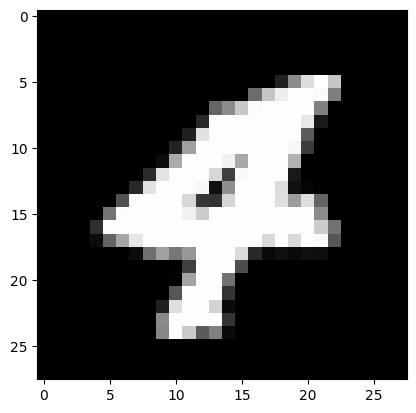

Prediction:  [5]
Label:  5


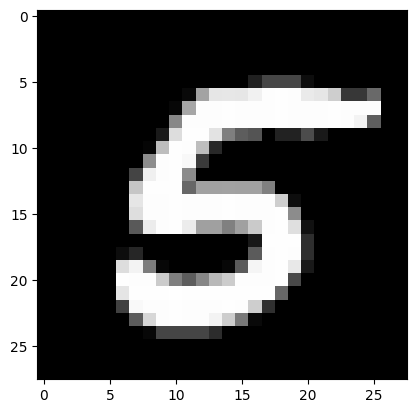

Prediction:  [8]
Label:  8


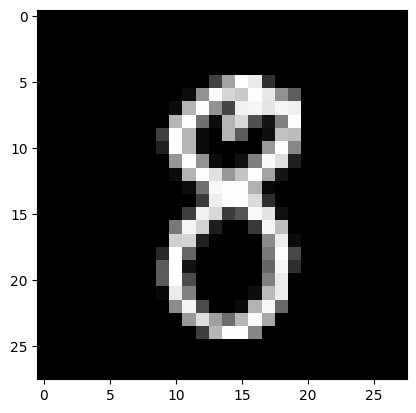

Prediction:  [1]
Label:  1


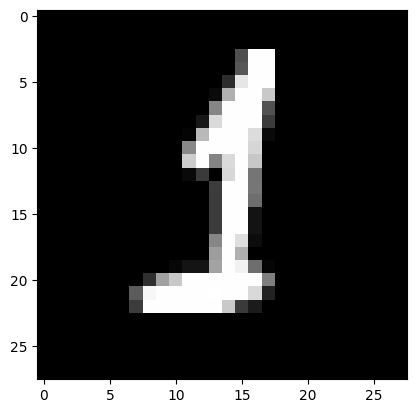

In [18]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)